In [ ]:
import os
import shutil
import zipfile

# GitHub repository URL
repo_url = 'https://github.com/atharvshimpi1/MRI_Brain_Tumor_dataset.git'
repo_dir = '/content/MRI_images_Dataset'

# Clear the existing directory if it exists
if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)

# Clone the repository
print(f'Cloning repository from {repo_url}...')
os.system(f'git clone {repo_url} {repo_dir}')
print('Repository cloned.')

# Navigate to the dataset directory
dataset_dir = os.path.join(repo_dir, 'datasets')
os.makedirs(dataset_dir, exist_ok=True)

# Unzip any zip files found in the dataset directory
for item in os.listdir(dataset_dir):
    if item.endswith('.zip'):
        file_path = os.path.join(dataset_dir, item)
        print(f'Extracting {file_path}...')
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)
        os.remove(file_path)  # Optionally remove the zip file after extraction
        print(f'{item} extracted.')

# Verify the files in the dataset directory
print('Data source import complete.')
print("Files in dataset directory:")
print(os.listdir(dataset_dir))


Cloning repository from https://github.com/atharvshimpi1/MRI_Brain_Tumor_dataset.git...
Repository cloned.
Data source import complete.
Files in dataset directory:
[]


## <p style="font-family:newtimeroman;font-size:150%;text-align:center;">Brain Tumor Detection using<br>EfficientNetB0, ResNet101, and Xception</p>

# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Introduction</p>

In my previous exploration of the Brain Tumor dataset ([Brain Tumor Detection using Tensorflow CNN](https://www.kaggle.com/code/anitarostami/brain-tumor-detection-using-tensorflow-cnn#notebook-container)), I delved into Image Classification using CNNs and compared augmented and unaugmented models. While both approaches provided insights, the unaugmented model shown potential for balancing accuracy and computational efficiency . However, due to the dataset's size limits, reaching ideal accuracy remained difficult. In this new notebook, I switch to Transfer Learning and use pre-trained models like EfficientNetB0, ResNet101, and Xception to significantly enhance classification accuracy.

<div class="alert alert-block alert-info"> <b>NOTE</b> I hope you found value and insights in this notebook. If you have any suggestions or thoughts, please feel free to share them. If you enjoyed the content, consider giving it an upvote. Thank you! </div>

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. DATA PREPRATION](#2)
    
* [2. TRANSFER LEARNING](#3)
    
* [3. EfficientNetB0](#4)
    
* [4. ResNet101](#5)   
      
* [6. Xception](#6)
    
* [7. CONCLUSION](#7)

<a id="1"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Importing Libraries</p>

In [ ]:
!pip install mplcyberpunk

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/MRI_images_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0791.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0917.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0725.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_1130.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0229.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0630.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0178.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0790.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0118.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0296.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0028.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0315.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_1256.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0930.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0595.jpg
/content/MRI_images_Dataset/Training/glioma/Tr-gl_0700.jpg
/cont

<a id="2"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Data Preperation</p>

In [ ]:
X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('../content/MRI_images_Dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('../content/MRI_images_Dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

  6%|▋         | 86/1339 [00:00<00:01, 850.64it/s]

## Data visualization

### Dataset Split: Train and Test

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One-Hot Encoding Labels

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

<a id="3"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Transfer Learning</p>

Transfer learning uses knowledge learned from training on one task to improve learning on another, which is especially beneficial when data is limited. The model can learn more quickly and avoid overfitting by using learned features from a related task. It works by starting with a pre-trained model's base layers, identifying transfer layers capturing relevant information, and fine-tuning these layers with new task data to adapt the model efficiently. This method is particularly useful in deep learning for tasks involving image recognition and classification.

**Fundamental Components and Techniques in Neural Network Training**

1. Dense: A fully connected layer that learns complicated patterns in data by connecting all neurons in the previous and subsequent layers.

2. GlobalAveragePooling2D: A pooling layer that determines the average value of each feature map across spatial dimensions, lowering spatial dimensions and keeping crucial information.

3. Dropout: a regularization technique that randomly sets a fraction of input units to zero during training, preventing overfitting and requiring the model to learn resilient features.

4. BatchNormalization: This technique normalizes each layer's activations to stabilize training and reduce internal covariate shift, resulting in faster convergence and improved generalization.

5. Callbacks: Callbacks are TensorFlow/Keras functions that can do specific actions during training, such as storing the model, adjusting learning rates, or halting training based on conditions.

6. Early Stopping: A callback technique that halts training when a monitored metric stops improving, preventing overfitting and conserving computational resources.

<a id="6"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Xception</p>

Xception, a revolutionary CNN architecture, incorporates depthwise separable convolutions, which reduces parameters and computational cost while maintaining efficacy. It uses separable convolutional blocks, an entry-exit flow structure, and skip connections similar to ResNet to provide efficient training and hierarchical feature learning. Key approaches include global depthwise convolutions for context understanding, data augmentation, batch normalization for stability, and transfer learning potential from ImageNet. With 71 layers, pretrained Xception performs at ImageNet classification, demonstrating its efficiency and adaptability in deep learning tasks.

In [ ]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'] 

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

NameError: name 'model' is not defined

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Evaluation</p>

## <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Prediction</p>

1/1 [==============================] - 0s 63ms/step
Predicted label: meningioma 
Actual label: meningioma 
Confidence: 99.99%



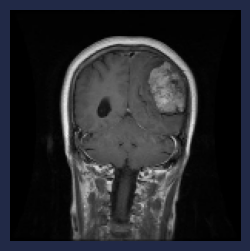

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


**Using Trained Model Import from Google Drive**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
from tensorflow.keras.applications.efficientnet import preprocess_input

# Upload an image file
uploaded = files.upload()

# Assume the user uploads only one image, so we take the first file
img_path = list(uploaded.keys())[0]

# Load the image
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to an array
img_array = image.img_to_array(img)

# Expand dimensions to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (if required by the model, e.g., EfficientNet)
img_array = preprocess_input(img_array)

# Predict the class for the selected image
predictions = model.predict(img_array)

# Interpret the model's predictions
predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[91mConfidence: {confidence*100:.2f}%\033[0m\n")

# Plot the image
plt.figure(figsize=(3, 3))
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.show()


IndexError: list index out of range

1/1 [==============================] - 0s 59ms/step
Predicted label: glioma 
Actual label: glioma 
Confidence: 99.93%



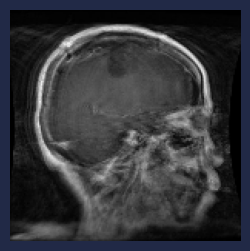

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [ ]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536, activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite format and saved as 'model.tflite'.")


Model successfully converted to TensorFlow Lite format and saved as 'model.tflite'.


<a id="7"></a>
# <p style="background-color:#003166;font-family:newtimeroman;font-size:150%;text-align:center;border-radius:50px 10px;">Conclusion</p>

Through the exploration of Transfer Learning models, including EfficientNet-b0, ResNet101, VGG 19, and Xception, this notebook has showcased the power of leveraging pre-existing knowledge to enhance classification accuracy. These models offer a robust framework for tackling the challenges posed by small datasets, exhibiting improved performance and paving the way for more accurate brain tumor detection.

# <p><center style="color:#003166;font-family:newtimeroman;;">Thank You!</center></p>